# Model pipeline
Let's start with our prepared dataset:

In [1]:
import pandas as pd
weather_train_scaled = pd.read_csv('data/weather_train_scaled.csv')

To define a classifier, we need to say what is the input data (`X`) and what is the target (`y`).
For now, we focus on only the numerical features

In [2]:
features = weather_train_scaled.columns[:-1]
print(features)

Index(['BASEL_cloud_cover', 'BASEL_humidity', 'BASEL_pressure',
       'BASEL_global_radiation', 'BASEL_precipitation', 'BASEL_sunshine',
       'BASEL_temp_mean', 'BASEL_temp_min', 'BASEL_temp_max',
       'BUDAPEST_cloud_cover',
       ...
       'STOCKHOLM_temp_min', 'STOCKHOLM_temp_max', 'TOURS_wind_speed',
       'TOURS_humidity', 'TOURS_pressure', 'TOURS_global_radiation',
       'TOURS_precipitation', 'TOURS_temp_mean', 'TOURS_temp_min',
       'TOURS_temp_max'],
      dtype='object', length=163)


In [3]:
X = weather_train_scaled[features]
y = weather_train_scaled['BASEL_BBQ_weather']

## Understanding the KNearestNeighboursClassifier

In [4]:
from sklearn.neighbors import KNeighborsClassifier

In [5]:
# First we define the model and its parameters,
classifier = KNeighborsClassifier(n_neighbors=3) # we look at 3 nearest neihbours, see intuition below
# Now we train it on the data
classifier.fit(X, y)

KNeighborsClassifier(n_neighbors=3)

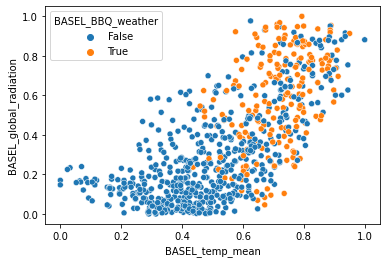

In [6]:
# We want to create a plot to get an intuition for how KNearestNeighboursClassifier works
# Let's plot two features against each other (I picked these based on the pairplot from yesterday).
# Let's add colourcoding for the different labels
import seaborn as sns
_ = sns.scatterplot(data=weather_train_scaled,
                    x='BASEL_temp_mean',
                    y='BASEL_global_radiation',
                    hue='BASEL_BBQ_weather'
                    )

### Intuition for KNeighborsClassifier
1. Given the features for a sample in the test set (for example BASEL_temp_mean = 0.2 BASEL_global_radiation = 0.1)
2. We find the 'k' closest data points from the training set (the nearest neighbours)
3. We take the label that the majority of the nearest neighbours has as our prediction

An example of instance-based learning or non-generalizing learning: it does not attempt to construct a general internal model, but simply stores instances of the training data

## Understanding the Decision Tree Classifier
We try out a Decision Tree classifier. This classifier tries to find smart splits in the data and assigns a class to every leaf of the tree. We will dive into the intuition later.

In [7]:
from sklearn.tree import DecisionTreeClassifier

In [48]:
# First we define the model and its parameters, in this case we pick 6 max leaf nodes so we can easily plot the decision tree.
classifier = DecisionTreeClassifier(max_leaf_nodes=6)
# Now we train it on the data
classifier.fit(X, y)

DecisionTreeClassifier(max_leaf_nodes=6)

#### Plotting the decision tree

In [49]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

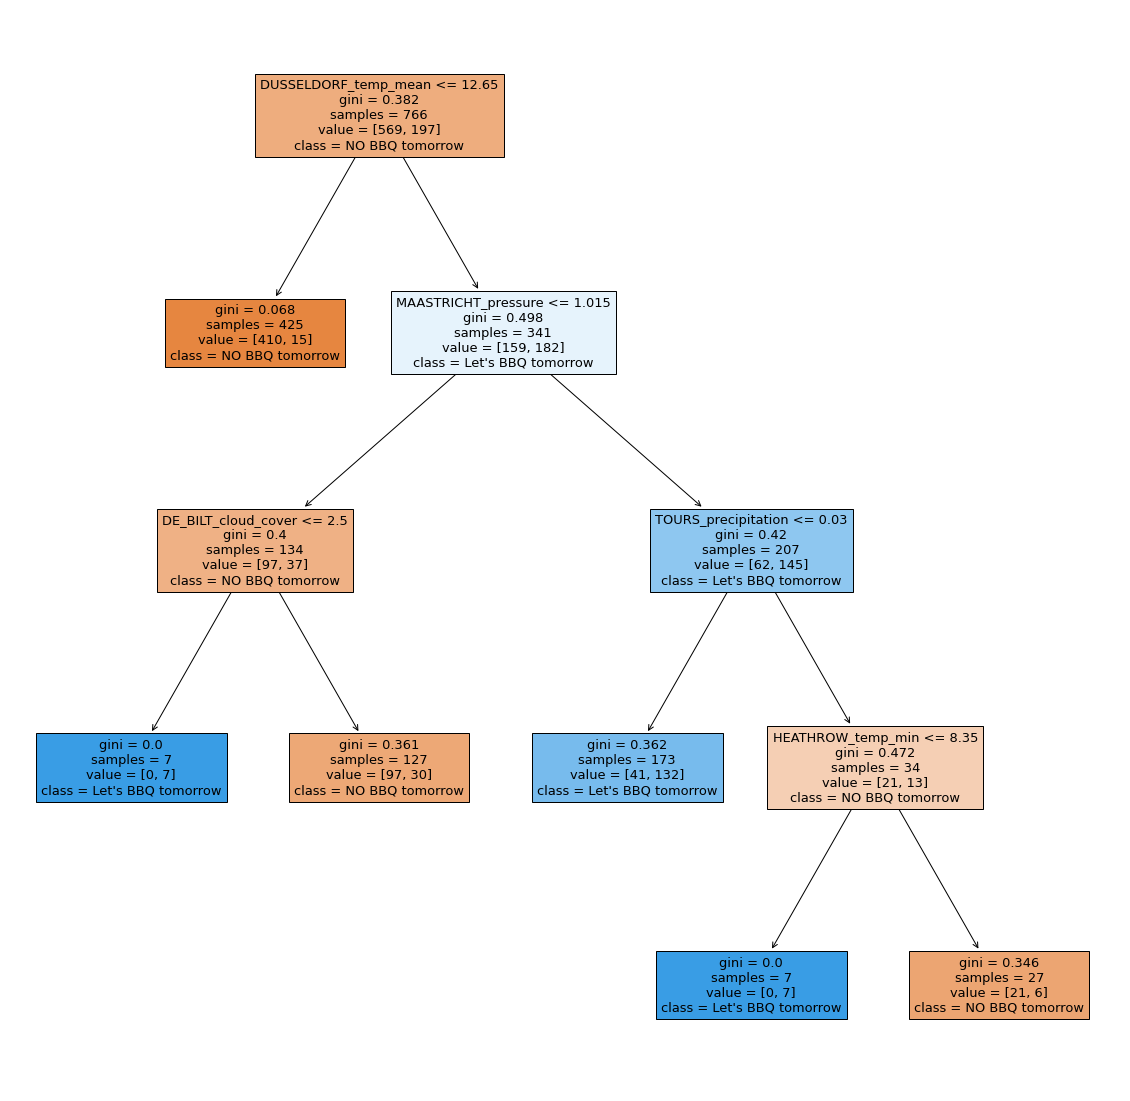

In [56]:
# To get an intution for decision trees, we are going to visualize the decision tree
# We will create a function so we can reuse it later
def plot_decision_tree(decision_tree_classifier):
    _ = plot_tree(decision_tree_classifier, 
                  filled=True,
                  feature_names=features,
                  class_names=['NO BBQ tomorrow', "Let's BBQ tomorrow"]
    )
_, ax = plt.subplots(figsize=(20, 20)) # This is to make it readable
plot_decision_tree(classifier)

### What do we see in this plot?
- **root node**: The top node that represents the entire training set
- **decision node**: When a sub-node splits into further sub-nodes
- **leaf node**: When a node doesn't split further, this represents one of the classes

### Intuition for decision tree algorithm(s)
The goal for the algorithm is to get leaf nodes that only have samples from one of the classes.

At each decision node, the algorithm tries to search for a variable which gives the maximum information gain or divides the data in the most homogeneous way.

## Let's train another decision tree classifier and see how it performs

In [11]:
# First we define the model and its parameters, in this case the minimal number of samples required to split a node.
classifier = DecisionTreeClassifier(min_samples_leaf=2)
# Now we train it on the data
classifier.fit(X, y)

DecisionTreeClassifier(min_samples_leaf=2)

We can now use our classifier to make predictions:

In [12]:
predictions = classifier.predict(X)
predictions[:10]

array([False, False, False, False, False, False, False, False,  True,
       False])

and compare this with the true target labels, for example using a confusion matrix. The rows in the confusion matrix 
are the true labels and the columns are the predicted labels

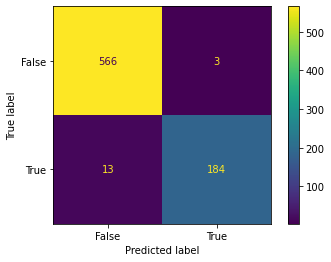

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(classifier, X, y)

### Exercise
Discuss in groups: What do you observe in the confusion matrix? Does the confusion matrix help you decide whether the model will perform well enough on new data?

Answer: The model seems to do very well, the highest values can be found on the diagonal which are correct predictions.
However, we predict on the same data that we trained on. To get a fair estimate of the perfomance, we need to apply it on a new data set, such as the test set

## Pipelines
Ok, suppose we want to predict on our test set. But remember, we also did a data transformation, namely scaling, in the preprocessing phase. We need to do the exact same steps for our test set!

To make it easier to reproduce all steps for new datasets, and to make sure that for each step, the train-test split is well guarded, sklearn provides pipeline. 
So we start again with the unscaled data, but now define a pipeline:

In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [15]:
weather_train = pd.read_csv('data/weather_train.csv')
X = weather_train[features]
y = weather_train['BASEL_BBQ_weather']

In [16]:
# We give the pipeline tuples of step names, and step objects
pipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('model', DecisionTreeClassifier())
])

In [17]:
pipe.fit(X, y)

Pipeline(steps=[('scale', MinMaxScaler()), ('model', DecisionTreeClassifier())])

To now test in on our test set: (note that we still have to drop null values)

In [18]:
weather_test = pd.read_csv('data/weather_test.csv')
X_test = weather_test[features]
y_test = weather_test['BASEL_BBQ_weather']

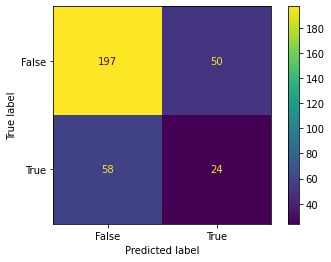

In [19]:
ConfusionMatrixDisplay.from_estimator(classifier, X_test, y_test)

It seems that the confusion matrix is worse than the one on the train set, but it is difficult to draw this conclusion from the confusion matrix alone. It would be nice to have one score that expresses how well our model does.

We calculate *accuracy*: this is the number of correctly labeled instances, divided the total number of instances. Note that this score works well when we have a balanced dataset (similar number of instances per class) but if we have imbalanced class, the majority class can dominate the score.

In [20]:
from sklearn.metrics import accuracy_score

In [21]:
pred_test = pipe.predict(X_test)
print('Train accuracy:', accuracy_score(y, predictions))
print('Test accuracy:', accuracy_score(y_test, pred_test))

Train accuracy: 0.97911227154047
Test accuracy: 0.7872340425531915


But what is our accuracy if we always predict `False` (which is the majority class)?

In [22]:
accuracy_score(y_test, [False]*len(y_test))

0.7507598784194529

So it turns out our model does not perform so well in real life afer all.. Even though it performs well on the training dataset.
This is called 'overfitting'

**Exercise** Thinking back at the theory on decision trees, what approaches could we take to prevent overfitting?

**Answer**: If we don't limit the size of the tree, the algorithm could create a tree that exactly fits our training data, and each data point will have its own leaf in the tree. However, such a model does not generalize to other data, and will perform worse on unseen data. By restricting how specific the tree can fit the data, for example by limiting its size, we may generalize better over other data. 

In [23]:
tree_model = pipe.named_steps['model']
tree_model

DecisionTreeClassifier()

In [24]:
tree_model.get_depth()

14

## Understanding the random forest classifier

One approach to reduce overfitting is using ensembles.

An ensemble takes multiple individual learning models and combines them to produce an aggregate model that is more powerful than any of its individual learning models alone.

Why are ensembles effective?
If we have different learning models, although each of them might perform well individually, they'll tend to make different kinds of mistakes on the data set. And typically, this happens because each individual model might overfit to a different part of the data. By combining different individual models into an ensemble, we can average out their individual mistakes to reduce the risk of overfitting while maintaining strong prediction performance.

Let's take a look at the random forest classifier and understand how it works

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
# First we define the model and its parameters, check the input parameters and notice that there is a lot of overlap with the decision tree
classifier = RandomForestClassifier(max_leaf_nodes=3)
# Now we train it on the data
classifier.fit(X, y)

RandomForestClassifier(max_leaf_nodes=3)

Note that we just trained a 100 decision tree classifiers, so it is a collection of trees: a forest


In [60]:
print(len(classifier.estimators_))
print(classifier.estimators_[0])

100
DecisionTreeClassifier(max_features='auto', max_leaf_nodes=3,
                       random_state=600069304)


Let's plot some of those decision trees and notice that they are a little bit different

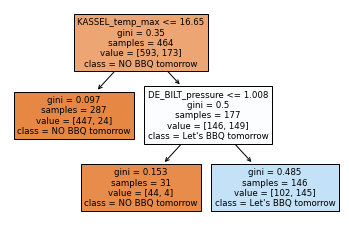

In [64]:
plot_decision_tree(classifier.estimators_[0])

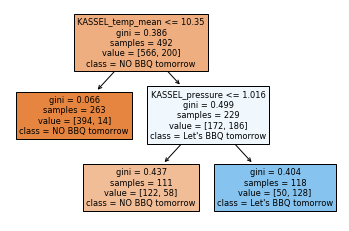

In [65]:
plot_decision_tree(classifier.estimators_[1])

#### How are the different predictions from the individual trees combined to one prediction?
For random forest this is done using averaging (basically taking the majority vote)
This type of ensemble learning is called 'bagging', there are other types of ensemble learning that we will not cover.

#### What is random about a random forest?
For each decision tree we (can) take a random subset of the samples in the data and/or a random subset of the features.
This makes each decision tree based on slightly different information, and probably slightly overfit to that part of the data. This is then smoothed out because we ensemble.

### Exercise (20 minutes)
1. Together with your neighbour choose another classifier from https://scikit-learn.org/stable/supervised_learning.html, just pick something that sounds cool to you. Train it on the data and check the accuracy on the train and the test set. Does it perform better or worse than the decision tree?
2. Try to understand how the algorithm works from the documentation.
3. (optional) Read more about scalers: https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler and swap the MinMaxScaler in your pipeline for another one. Interpret the results.